In [1]:
#import modules
from statsbombpy import sb

import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier

import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
from bs4 import BeautifulSoup
import requests

In [3]:
competitions = sb.competitions()

In [4]:
help(sb.matches)

Help on function matches in module statsbombpy.sb:

matches(competition_id: int, season_id: int, fmt='dataframe', creds: dict = {'user': None, 'passwd': None})



In [5]:
# events = sb.competition_events(
#     country="England",
#     division= "Premier League",
#     season="2015/2016",
#     gender="male"
# )

In [6]:
#events.columns

In [7]:
competitions[
    (competitions['competition_name'].isin([
    'Premier League', '1. Bundesliga', 'La Liga', 'Ligue 1', 'Serie A']))
             & 
    (competitions['season_name']=='2015/2016')
            ]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
41,11,27,Spain,La Liga,male,False,False,2015/2016,2023-09-20T17:21:32.111535,2021-06-13T16:17:31.694,None,2023-09-20T17:21:32.111535
58,7,27,France,Ligue 1,male,False,False,2015/2016,2023-12-13T00:27:57.162379,None,None,2023-12-13T00:27:57.162379
62,2,27,England,Premier League,male,False,False,2015/2016,2023-11-14T11:25:33.476498,2021-06-13T16:17:31.694,None,2023-11-14T11:25:33.476498
64,12,27,Italy,Serie A,male,False,False,2015/2016,2023-12-13T17:32:46.423081,None,None,2023-12-13T17:32:46.423081


In [8]:
#competitions[competitions['competition_name']=='Champions League']

In [9]:
Bundesliga = sb.matches(competition_id=9, season_id=27)
Bundesliga.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3890561,2016-05-14,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Hoffenheim,Schalke 04,1,4,available,...,None,34,Regular Season,PreZero Arena,Felix Brych,Julian Nagelsmann,André Breitenreiter,1.1.0,2,2
1,3890505,2016-04-02,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Bayern Munich,Eintracht Frankfurt,1,0,available,...,None,28,Regular Season,Allianz Arena,Florian Meyer,Josep Guardiola i Sala,Niko Kovač,1.1.0,2,2
2,3890511,2016-04-08,20:30:00.000,Germany - 1. Bundesliga,2015/2016,Hertha Berlin,Hannover 96,2,2,available,...,None,29,Regular Season,Olympiastadion Berlin,Benjamin Brand,Pál Dárdai,Daniel Stendel,1.1.0,2,2
3,3890515,2016-04-09,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Hamburger SV,Darmstadt 98,1,2,available,...,None,29,Regular Season,Volksparkstadion,Peter Sippel,Bruno Labbadia,Dirk Schuster,1.1.0,2,2
4,3890411,2015-12-20,16:30:00.000,Germany - 1. Bundesliga,2015/2016,Hertha Berlin,FSV Mainz 05,2,0,available,...,None,17,Regular Season,Olympiastadion Berlin,Peter Sippel,Pál Dárdai,Martin Schmidt,1.1.0,2,2


In [10]:
Bundesliga.columns

Index(['match_id', 'match_date', 'kick_off', 'competition', 'season',
       'home_team', 'away_team', 'home_score', 'away_score', 'match_status',
       'match_status_360', 'last_updated', 'last_updated_360', 'match_week',
       'competition_stage', 'stadium', 'referee', 'home_managers',
       'away_managers', 'data_version', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object')

In [11]:
print(pd.unique(Bundesliga['home_team']))

['Hoffenheim' 'Bayern Munich' 'Hertha Berlin' 'Hamburger SV'
 'Borussia Dortmund' 'Wolfsburg' 'Schalke 04' 'FSV Mainz 05' 'Augsburg'
 'Bayer Leverkusen' 'Darmstadt 98' 'Werder Bremen' 'FC Köln'
 'Eintracht Frankfurt' 'VfB Stuttgart' 'Borussia Mönchengladbach'
 'Ingolstadt' 'Hannover 96']


In [12]:
elevations = {'King Power Stadium ': 57, 'The Hawthorns': 166, "St. James'' Park": 78, 'Goodison Park': 47,
 'Selhurst Park': 54, 'Emirates Stadium': 31, 'White Hart Lane': 20, 'Stadium of Light': 40,
 'Villa Park': 105, 'Anfield ': 66, 'bet365 Stadium': 131, 'Old Trafford':43,
 'Vitality Stadium': 33,'Swansea.com Stadium': 15, "St. Mary''s Stadium": 1,
 'Carrow Road': 7, 'Stamford Bridge':11, 'Vicarage Road':70, 'Etihad Stadium': 60,
 'Boleyn Ground':11}

In [13]:
Bundesliga.iloc[0]

match_id                                    3890561
match_date                               2016-05-14
kick_off                               15:30:00.000
competition                 Germany - 1. Bundesliga
season                                    2015/2016
home_team                                Hoffenheim
away_team                                Schalke 04
home_score                                        1
away_score                                        4
match_status                              available
match_status_360                        unscheduled
last_updated             2023-07-24T07:47:12.510532
last_updated_360                               None
match_week                                       34
competition_stage                    Regular Season
stadium                               PreZero Arena
referee                                 Felix Brych
home_managers                     Julian Nagelsmann
away_managers                   André Breitenreiter
data_version

In [14]:
example = sb.events(match_id=3754037)
example.columns

Index(['ball_receipt_outcome', 'ball_recovery_offensive',
       'ball_recovery_recovery_failure', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_right_foot', 'counterpress',
       'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_technique', 'goalkeeper_type', 'id',
       'index', 'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_end_location', 'pass_goal_assist', 'pass_height',
   

In [15]:
relevant_attributes = ['minute', 'second', 'team', 'shot_statsbomb_xg',
                       'player', 'position', 'location', 'shot_body_part',
       'shot_end_location', 'shot_first_time', 
         'shot_technique',
       'shot_type', 'type','shot_outcome']

In [16]:
# check_attributes = ['pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
#        'pass_cut_back', 'pass_end_location', 'pass_goal_assist', 'pass_height',
#        'pass_inswinging', 'pass_length', 'pass_no_touch', 'pass_outcome',
#        'pass_outswinging', 'pass_recipient', 'pass_recipient_id',
#        'pass_shot_assist', 'pass_straight', 'pass_switch', 'pass_technique',
#        'pass_type', 'type', 'shot_outcome', 'location']
# first_match_df = pd.DataFrame(columns=check_attributes)
# for match in PremierLeague['match_id'][:1]:
#     match_df = sb.events(match_id=match)
#     relevant_match_df = match_df[relevant_attributes][match_df['type']=='Shot']
#     first_match_df = pd.concat([first_match_df, relevant_match_df], ignore_index=True)

# first_match_df['shot_outcome'] = first_match_df['shot_outcome'].replace(to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
#                'Saved to Post': 0, 'Saved Off Target': 0})

# first_match_df['distance'] = first_match_df.apply(lambda row: np.sqrt(np.abs(row.location[0]-120)**2 + 
#                                                      np.abs(row.location[1]-40)**2), axis=1)
# first_match_df

In [17]:
Bundesliga_shots_df = pd.DataFrame(columns=relevant_attributes)

In [18]:
start = time.time()
for match in Bundesliga['match_id']:#[:10]:
    match_df = sb.events(match_id=match)
    relevant_match_df = match_df[relevant_attributes][match_df['type']=='Shot']
    Bundesliga_shots_df = pd.concat([Bundesliga_shots_df, relevant_match_df], ignore_index=True)

Bundesliga_shots_df['shot_outcome'] = Bundesliga_shots_df['shot_outcome'].replace(
    to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
               'Saved to Post': 0, 'Saved Off Target': 0})

Bundesliga_shots_df['distance'] = Bundesliga_shots_df.apply(lambda row: np.sqrt(np.abs(
    row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
Bundesliga_shots_df['shot_angle'] = Bundesliga_shots_df.apply(
    lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
end = time.time()
print(f'script run time: {(end - start)/60} minutes')
Bundesliga_shots_df

script run time: 4.07833822965622 minutes


,minute,second,team,shot_statsbomb_xg,player,position,location,shot_body_part,shot_end_location,shot_first_time,shot_technique,shot_type,type,shot_outcome,distance,shot_angle
0,4,21,Hoffenheim,0.087901,Tarik Elyounoussi,Left Wing Back,"[108.1, 31.2]",Left Foot,"[120.0, 35.2, 1.0]",True,Half Volley,Open Play,Shot,0,14.800338,0.636744
1,6,27,Schalke 04,0.160274,Klaas-Jan Huntelaar,Center Forward,"[110.9, 42.6]",Right Foot,"[120.0, 39.3, 0.5]",True,Volley,Open Play,Shot,1,9.464143,0.278300
2,8,16,Hoffenheim,0.016036,Kevin Volland,Left Attacking Midfield,"[117.9, 29.1]",Left Foot,"[118.1, 30.2]",True,Half Volley,Open Play,Shot,0,11.100450,1.380468
3,13,55,Schalke 04,0.527759,Jean-Eric Maxim Choupo-Moting,Left Midfield,"[101.8, 27.6]",Left Foot,"[120.0, 39.0, 0.2]",NaN,Normal,Open Play,Shot,1,22.022716,0.598078
4,17,16,Schalke 04,0.074020,Klaas-Jan Huntelaar,Center Forward,"[109.3, 26.5]",Right Foot,"[118.8, 36.0, 0.2]",NaN,Normal,Open Play,Shot,0,17.226143,0.900588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,72,14,Bayern Munich,0.248334,Thomas Müller,Right Center Midfield,"[113.6, 30.4]",Left Foot,"[120.0, 38.9, 0.2]",NaN,Normal,Open Play,Shot,1,11.537764,0.982794
7827,77,17,Bayern Munich,0.028587,David Olatukunbo Alaba,Left Back,"[99.2, 25.5]",Left Foot,"[117.7, 36.8, 2.2]",NaN,Normal,Open Play,Shot,0,25.355276,0.608787
7828,83,16,Bayern Munich,0.007272,Douglas Costa de Souza,Right Midfield,"[106.5, 64.6]",Left Foot,"[120.0, 37.3, 3.6]",NaN,Normal,Open Play,Shot,0,28.060827,1.068890
7829,86,15,Bayern Munich,0.025284,Douglas Costa de Souza,Right Midfield,"[100.7, 57.0]",Left Foot,"[120.0, 37.0, 0.7]",NaN,Normal,Open Play,Shot,1,25.719448,0.722122


## Describing the Data

In [19]:
Bundesliga_shots_df.describe()

,shot_statsbomb_xg,shot_outcome,distance,shot_angle
count,7831.000000,7831.000000,7831.000000,7831.000000
mean,0.106079,0.106883,18.857774,0.484138
std,0.149561,0.308984,8.526150,0.327077
min,0.000180,0.000000,0.943398,0.000000
25%,0.027162,0.000000,11.900420,0.213905
50%,0.054641,0.000000,17.924564,0.440802
75%,0.110142,0.000000,25.187298,0.709912
max,0.977242,1.000000,84.986881,1.570796


In [20]:
Bundesliga_shots_df = Bundesliga_shots_df[Bundesliga_shots_df.shot_type != 'Corner']

In [21]:
Bundesliga_shots_df['shot_outcome'].value_counts()

shot_outcome
0    6988
1     837
Name: count, dtype: int64

In [22]:
Bundesliga_team_summary_df = pd.DataFrame(columns = ['team', 'shots', 'goals', 'statsbomb_xg'])
for team in pd.unique(Bundesliga_shots_df['team']):
    shot_sum = Bundesliga_shots_df['team'].value_counts()[team]
    goal_sum = sum(Bundesliga_shots_df[Bundesliga_shots_df['team']==team]['shot_outcome'])
    statsbomb_xg_sum = sum(Bundesliga_shots_df[Bundesliga_shots_df['team']==team]['shot_statsbomb_xg'])
    new_row = pd.Series({'team': team, 'shots': shot_sum, 'goals': goal_sum, 'statsbomb_xg': statsbomb_xg_sum})
    Bundesliga_team_summary_df.loc[len(Bundesliga_team_summary_df)]=new_row
Bundesliga_team_summary_df = Bundesliga_team_summary_df.sort_values(by=['shots'], ascending=False)
Bundesliga_team_summary_df

,team,shots,goals,statsbomb_xg
2,Bayern Munich,622,78,73.353521
9,Borussia Dortmund,524,80,77.142092
10,Wolfsburg,494,46,47.286714
11,VfB Stuttgart,490,48,53.967067
1,Schalke 04,486,47,45.795114
15,Bayer Leverkusen,479,51,49.798501
17,Borussia Mönchengladbach,457,64,49.197822
13,Werder Bremen,451,49,49.968887
12,Augsburg,439,40,41.013908
14,Ingolstadt,424,33,39.960963


In [23]:
Bundesliga_shots_df.columns

Index(['minute', 'second', 'team', 'shot_statsbomb_xg', 'player', 'position',
       'location', 'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_technique', 'shot_type', 'type', 'shot_outcome', 'distance',
       'shot_angle'],
      dtype='object')

## Training Model

In [24]:
cap_x_df, y_df = pd.concat([Bundesliga_shots_df.iloc[:,:-3], Bundesliga_shots_df.iloc[:,-2:]], axis=1),Bundesliga_shots_df.iloc[:,-3].to_frame()

In [25]:
train_cap_x_df, test_cap_x_df, train_y_df, test_y_df = \
train_test_split(cap_x_df, y_df,
                 test_size=0.20,
                random_state=42,
                 shuffle=True,
                stratify=y_df)

In [26]:
target_attr = 'shot_outcome'

In [27]:
numerical_attrs = ['distance', 'minute', 'shot_angle']

In [28]:
nominal_attrs = ['shot_technique', 'shot_type', 'shot_body_part', 'position', 'shot_first_time', 'position']

In [29]:
numerical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer()),
               ("scaler", StandardScaler())]
    )

In [30]:
nominal_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="most_frequent")),
               #('target_encoder', TargetEncoder(target_type=target_type, random_state=42)),
               ("target_encoder", OrdinalEncoder()),
               ("scaler", StandardScaler())
               ]
    )

In [31]:
preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, numerical_attrs),
            ('nominal', nominal_transformer, nominal_attrs)
        ]
    )

## Try with Logistic Regression

In [32]:
estimator = LogisticRegression()

In [33]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [34]:
composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'minute',
                                                   'shot_angle']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shot_technique',
                                                   'shot_type',
                                                   'shot_body_part', 'position',
                                                   'shot_first_time',
                                                   'position'])])),
                ('estimator', LogisticRegression())])

In [35]:
composite_estimator.predict_proba(train_cap_x_df)

array([[0.99737908, 0.00262092],
       [0.9584491 , 0.0415509 ],
       [0.95352963, 0.04647037],
       ...,
       [0.86612826, 0.13387174],
       [0.54711095, 0.45288905],
       [0.97775511, 0.02224489]])

In [36]:
print("Training set actual goal information")
print(train_y_df[target_attr].value_counts())
print("Training set naive model total xG",sum(composite_estimator.predict_proba(train_cap_x_df)[:,1]))
print("Training set Statsbomb total xG:", sum(train_cap_x_df['shot_statsbomb_xg']))

Training set actual goal information
shot_outcome
0    5590
1     670
Name: count, dtype: int64
Training set naive model total xG 670.00001497316
Training set Statsbomb total xG: 663.6382313521016


In [37]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    #.legend(label=outcome
    z = np.polyfit(model1, model2,1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

In [38]:
pd.unique(Bundesliga_shots_df['shot_type'])

array(['Open Play', 'Free Kick', 'Penalty'], dtype=object)

In [39]:
test_predictions = composite_estimator.predict_proba(test_cap_x_df)

In [40]:
print("Test set actual goal information")
print(test_y_df[target_attr].value_counts())
print("Test set naive model total xG", sum(test_predictions[:,1]))
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Test set actual goal information
shot_outcome
0    1398
1     167
Name: count, dtype: int64
Test set naive model total xG 162.34139520056812
Statsbomb total xG: 167.06751874890048


In [41]:
print(test_y_df[target_attr].value_counts())

shot_outcome
0    1398
1     167
Name: count, dtype: int64


In [42]:
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Statsbomb total xG: 167.06751874890048


In [43]:
SBModel = test_cap_x_df['shot_statsbomb_xg']
proposed_model = test_predictions[:,1]
shot_outcome = test_y_df[target_attr]

y=1.02x+0.00
$R^2$= 0.21546024293887145


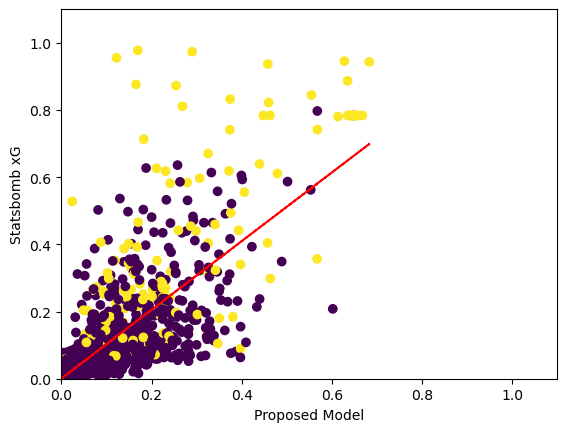

In [44]:
plot_comparison(proposed_model, "Proposed Model", SBModel, 'Statsbomb xG', shot_outcome)

## Try with SGDClassifier

In [45]:
estimator = SGDClassifier(
        loss='log_loss', 
        penalty='l2', 
        alpha=0.0001, 
        l1_ratio=0.15, 
        fit_intercept=True, 
        max_iter=1000, 
        tol=0.001, 
        shuffle=True, 
        verbose=0, 
        epsilon=0.1, 
        n_jobs=None, 
        random_state=42, 
        learning_rate='optimal', 
        eta0=0.0, 
        power_t=0.5, 
        early_stopping=False, 
        validation_fraction=0.1, 
        n_iter_no_change=5, 
        class_weight=None, 
        warm_start=False, 
        average=False
    )

In [46]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [47]:
composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'minute',
                                                   'shot_angle']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shot_technique',
                                                   'shot_type',
                                                   'shot_body_part', 'position',
                                                   'shot_first_time',
                                                   'position'])])),
                ('estimator', SGDClassifier(loss='log_loss', random_state=42))])

In [48]:
composite_estimator.predict_proba(train_cap_x_df)

array([[0.99885098, 0.00114902],
       [0.9790135 , 0.0209865 ],
       [0.96569714, 0.03430286],
       ...,
       [0.77702577, 0.22297423],
       [0.48605211, 0.51394789],
       [0.98440476, 0.01559524]])

In [49]:
print("Training set actual goal information")
print(train_y_df[target_attr].value_counts())
print("Training set naive model total xG",sum(composite_estimator.predict_proba(train_cap_x_df)[:,1]))
print("Training set Statsbomb total xG:", sum(train_cap_x_df['shot_statsbomb_xg']))

Training set actual goal information
shot_outcome
0    5590
1     670
Name: count, dtype: int64
Training set naive model total xG 662.072826117647
Training set Statsbomb total xG: 663.6382313521016


In [50]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    #.legend(label=outcome
    z = np.polyfit(model1, model2,1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

In [51]:
pd.unique(Bundesliga_shots_df['shot_type'])

array(['Open Play', 'Free Kick', 'Penalty'], dtype=object)

In [52]:
test_predictions = composite_estimator.predict_proba(test_cap_x_df)

In [53]:
print("Test set actual goal information")
print(test_y_df[target_attr].value_counts())
print("Test set naive model total xG", sum(test_predictions[:,1]))
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Test set actual goal information
shot_outcome
0    1398
1     167
Name: count, dtype: int64
Test set naive model total xG 159.14772835394768
Statsbomb total xG: 167.06751874890048


In [54]:
print(test_y_df[target_attr].value_counts())

shot_outcome
0    1398
1     167
Name: count, dtype: int64


In [55]:
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Statsbomb total xG: 167.06751874890048


In [56]:
SBModel = test_cap_x_df['shot_statsbomb_xg']
proposed_model = test_predictions[:,1]
shot_outcome = test_y_df[target_attr]

y=0.87x+0.02
$R^2$= 0.34082342242315244


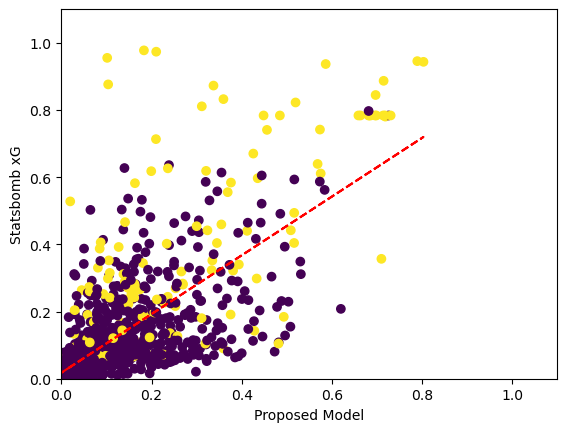

In [57]:
plot_comparison(proposed_model, "Proposed Model", SBModel, 'Statsbomb xG', shot_outcome)

## Try with RandomForest Classifier

In [58]:
estimator = RandomForestClassifier(
    n_estimators=500, 
    criterion='gini', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='sqrt', 
    max_leaf_nodes=16, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=-1, 
    random_state=42,
    verbose=0, 
    warm_start=False, 
    class_weight=None, 
    ccp_alpha=0.0, 
    max_samples=None
)

In [59]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [60]:
composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'minute',
                                                   'shot_angle']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shot_technique',
                                                   'shot_type',
                                                   'shot_body_part', 'position',
                                                   'shot_first_time',
                                                   'position'])])),
                ('estimator',
                 RandomForestClassifier(max_leaf_nodes=16, n_estimators=500,
                                        n_jobs=-1, random_state=42))])

In [61]:
composite_estimator.predict_proba(train_cap_x_df)

array([[0.94783279, 0.05216721],
       [0.94352143, 0.05647857],
       [0.91380794, 0.08619206],
       ...,
       [0.89202894, 0.10797106],
       [0.4485449 , 0.5514551 ],
       [0.94390986, 0.05609014]])

In [62]:
print("Training set actual goal information")
print(train_y_df[target_attr].value_counts())
print("Training set naive model total xG",sum(composite_estimator.predict_proba(train_cap_x_df)[:,1]))
print("Training set Statsbomb total xG:", sum(train_cap_x_df['shot_statsbomb_xg']))

Training set actual goal information
shot_outcome
0    5590
1     670
Name: count, dtype: int64
Training set naive model total xG 667.2661086929527
Training set Statsbomb total xG: 663.6382313521016


In [63]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    #.legend(label=outcome
    z = np.polyfit(model1, model2,1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

In [64]:
pd.unique(Bundesliga_shots_df['shot_type'])

array(['Open Play', 'Free Kick', 'Penalty'], dtype=object)

In [65]:
test_predictions = composite_estimator.predict_proba(test_cap_x_df)

In [66]:
print("Test set actual goal information")
print(test_y_df[target_attr].value_counts())
print("Test set naive model total xG", sum(test_predictions[:,1]))
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Test set actual goal information
shot_outcome
0    1398
1     167
Name: count, dtype: int64
Test set naive model total xG 163.39292946657082
Statsbomb total xG: 167.06751874890048


In [67]:
print(test_y_df[target_attr].value_counts())

shot_outcome
0    1398
1     167
Name: count, dtype: int64


In [68]:
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Statsbomb total xG: 167.06751874890048


In [69]:
SBModel = test_cap_x_df['shot_statsbomb_xg']
proposed_model = test_predictions[:,1]
shot_outcome = test_y_df[target_attr]

y=1.30x+-0.03
$R^2$= -0.14682261942018182


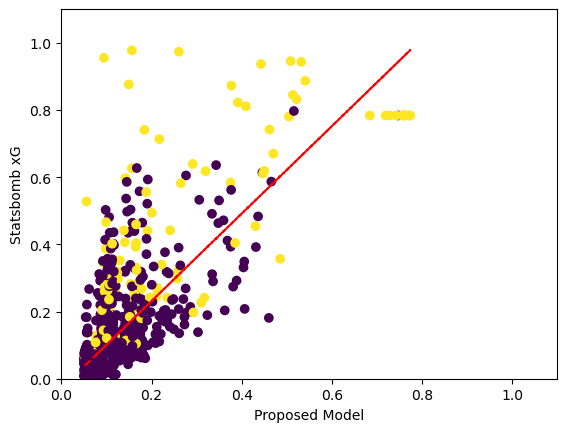

In [70]:
plot_comparison(proposed_model, "Proposed Model", SBModel, 'Statsbomb xG', shot_outcome)